In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import geopandas as gpd

df = pd.read_csv("../CSV/2010-2021.csv")

# create grouping of data using specified column
groupby_borough = df.groupby(['BOROUGH'])

# creates a copy of specified entry within the column group
borough = groupby_borough.get_group(('BRONX',)).copy()
borough.drop('LOWEST SALE PRICE', axis=1, inplace=True)
borough.drop('HIGHEST SALE PRICE', axis=1, inplace=True)

# group further by home type
groupby_home = borough.groupby(['TYPE OF HOME'])
three = groupby_home.get_group(('03 THREE FAMILY HOMES',)).copy()

# set up to do regession 
hood_names_three = three['NEIGHBORHOOD'].unique()
groupby_hood = three.groupby(['NEIGHBORHOOD'])
# addresses small samples
small_sample = []

# prediction model
dic_three = {}
for h in hood_names_three:
    temp = groupby_hood.get_group((h,)).copy()
    # print(h)
    if h in small_sample:
        dic_three[h] = temp['AVERAGE SALE PRICE'].item()
    else:
        X = temp[['YEAR', 'MEDIAN SALE PRICE', 'NUMBER OF SALES']]
        y = temp['AVERAGE SALE PRICE']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        dic_three[h] = y_pred[0]

# map of neighborhood
shape = gpd.read_file("../nynta2020_24b/nynta2020.shp")

# removes all borough that isn't the working set
to_drop = shape[shape["BoroName"] != "Bronx"].index 
shape.drop(to_drop, inplace=True) 

# removes all other columns that we don't really care for
shape = shape.drop(columns=["BoroCode", "BoroName", "CountyFIPS", "NTA2020", "NTAAbbrev", "NTAType", "CDTA2020", "Shape_Leng", "Shape_Area", "CDTAName"])

hood_names_three 

array(['BATHGATE', 'BAYCHESTER', 'BEDFORD PARK/NORWOOD', 'BELMONT',
       'BRONXDALE', 'CASTLE HILL/UNIONPORT', 'CITY ISLAND',
       'COUNTRY CLUB', 'CROTONA PARK', 'EAST TREMONT', 'FORDHAM',
       'HIGHBRIDGE/MORRIS HEIGHTS', 'HUNTS POINT',
       'KINGSBRIDGE HTS/UNIV HTS', 'KINGSBRIDGE/JEROME PARK',
       'MELROSE/CONCOURSE', 'MORRIS PARK/VAN NEST', 'MORRISANIA/LONGWOOD',
       'MOTT HAVEN/PORT MORRIS', 'MOUNT HOPE/MOUNT EDEN', 'PARKCHESTER',
       'PELHAM GARDENS', 'PELHAM PARKWAY NORTH', 'PELHAM PARKWAY SOUTH',
       'RIVERDALE', 'SCHUYLERVILLE/PELHAM BAY', 'SOUNDVIEW',
       'THROGS NECK', 'WAKEFIELD', 'WESTCHESTER', 'WILLIAMSBRIDGE',
       'WOODLAWN', 'FIELDSTON'], dtype=object)

In [6]:
pairs = {
    'Mott Haven-Port Morris': 'MOTT HAVEN/PORT MORRIS',
    'Melrose': 'MELROSE/CONCOURSE',
    'Hunts Point': 'HUNTS POINT',
    'Longwood': 'MORRISANIA/LONGWOOD',
    'North & South Brother Islands': None,
    'Morrisania': 'MORRISANIA/LONGWOOD',
    'Claremont Village-Claremont (East)': 'MORRISANIA/LONGWOOD',
    'Crotona Park East': 'CROTONA PARK',
    'Crotona Park': 'CROTONA PARK',
    'Concourse-Concourse Village': 'MELROSE/CONCOURSE',
    'Highbridge': 'HIGHBRIDGE/MORRIS HEIGHTS',
    'Mount Eden-Claremont (West)': 'MOUNT HOPE/MOUNT EDEN',
    'Yankee Stadium-Macombs Dam Park': 'HIGHBRIDGE/MORRIS HEIGHTS',
    'Claremont Park': 'MORRISANIA/LONGWOOD',
    'University Heights (South)-Morris Heights': 'HIGHBRIDGE/MORRIS HEIGHTS',
    'Mount Hope': 'MOUNT HOPE/MOUNT EDEN',
    'Fordham Heights': 'FORDHAM',
    'West Farms': 'WESTCHESTER',
    'Tremont': 'EAST TREMONT',
    'Belmont': 'BELMONT',
    'University Heights (North)-Fordham': 'FORDHAM',
    'Bedford Park': 'BEDFORD PARK/NORWOOD',
    'Norwood': 'BEDFORD PARK/NORWOOD',
    'Kingsbridge Heights-Van Cortlandt Village': 'KINGSBRIDGE HTS/UNIV HTS',
    'Kingsbridge-Marble Hill': 'KINGSBRIDGE/JEROME PARK',
    'Riverdale-Spuyten Duyvil': 'RIVERDALE',
    'Soundview-Bruckner-Bronx River': 'SOUNDVIEW',
    'Soundview-Clason Point': 'SOUNDVIEW',
    'Castle Hill-Unionport': 'CASTLE HILL/UNIONPORT',
    'Parkchester': 'PARKCHESTER',
    'Soundview Park': 'SOUNDVIEW',
    'Westchester Square': 'WESTCHESTER',
    'Throgs Neck-Schuylerville': 'THROGS NECK',
    'Pelham Bay-Country Club-City Island': 'CITY ISLAND',
    'Co-op City': None,
    'Hart Island': None,
    'Ferry Point Park-St. Raymond Cemetery': None,
    'Pelham Parkway-Van Nest': 'PELHAM PARKWAY NORTH',
    'Morris Park': 'MORRIS PARK/VAN NEST',
    'Pelham Gardens': 'PELHAM GARDENS',
    'Allerton': None,
    'Hutchinson Metro Center': None,
    'Williamsbridge-Olinville': 'WILLIAMSBRIDGE',
    'Eastchester-Edenwald-Baychester': 'BAYCHESTER',
    'Wakefield-Woodlawn': 'WAKEFIELD',
    'Woodlawn Cemetery': 'WOODLAWN',
    'Van Cortlandt Park': 'FIELDSTON',
    'Bronx Park': None,
    'Pelham Bay Park': None,
    'Rikers Island': None
}


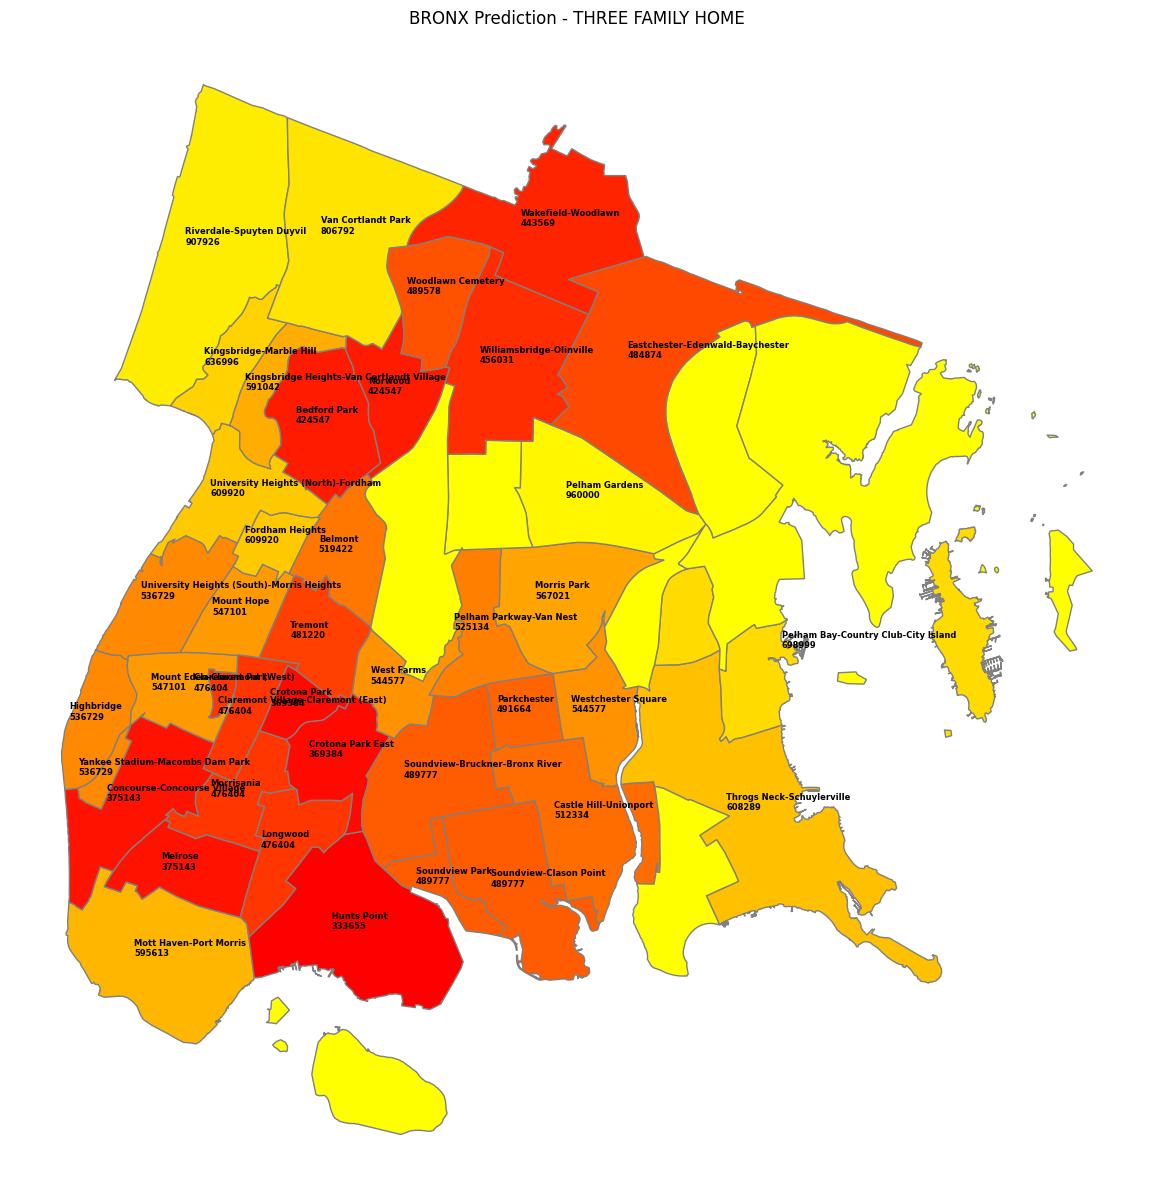

In [7]:
import matplotlib.pyplot as plt

shape['sales'] = "-"

# adding sales data to overall df
for i, row in shape.iterrows():
    holder = pairs[row['NTAName']]
    if holder:
        if isinstance(holder, list):
            sum = 0
            for e in holder:
                sum += dic_three[e]
            shape.at[i, 'sales'] = int(sum/len(holder))
        else:
            shape.at[i, 'sales'] = int(dic_three[holder])

# sets map settings
shape_map = shape.plot(column='sales', k=8, cmap='autumn', figsize=(30,15), linewidth=1, edgecolor='0.5')
# adds labels to map
for i, row in shape.iterrows():
    x = row['geometry'].centroid.x
    y = row['geometry'].centroid.y
    if row['sales'] != "-" :
        label = row['NTAName'] + "\n" + str(row['sales'])
        shape_map.annotate(label, xy=(x, y), xytext=(-20, 0), color="black", textcoords="offset points", fontsize=6, weight="bold")
# draws the map
shape_map.set(title="BRONX Prediction - THREE FAMILY HOME")
shape_map.set_axis_off()